## In this practical session, We'll cover:

1.   Implement and train CLIP
2.   Use a pre-trained CLIP for zero-shot prediction
3.   Stable Diffusion - Train classifier-free guidance diffusion.


# Install package

In [5]:
! pip install ftfy regex tqdmd
! pip install git+https://github.com/openai/CLIP.git

ERROR: Could not find a version that satisfies the requirement tqdmd (from versions: none)
ERROR: No matching distribution found for tqdmd
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ca4xs4zd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ca4xs4zd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


# Import library

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import os
import pandas as pd
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.optim as optim
from collections import OrderedDict
import torch
from collections import OrderedDict
from torch.optim import Adam
import numpy as np
import torch
from pkg_resources import packaging
import torch.nn.functional as F
from pkg_resources import packaging
import clip

Download the .py file for tokenizer

In [7]:
!git clone https://github.com/ttumyche/AI504_Practice14.git
!mv AI504_Practice14/simple_tokenizer.py /content/
!mv AI504_Practice14/bpe_simple_vocab_16e6.txt.gz /content/

fatal: destination path 'AI504_Practice14' already exists and is not an empty directory.
mv: cannot stat 'AI504_Practice14/simple_tokenizer.py': No such file or directory
mv: cannot stat 'AI504_Practice14/bpe_simple_vocab_16e6.txt.gz': No such file or directory


In [8]:
from simple_tokenizer import SimpleTokenizer

tokenizer = SimpleTokenizer()
def tokenize_text(tokenizer, text, max_length):
    tokens = tokenizer.encode(text)
    if len(tokens) == 0:
        print(f"Empty tokens for text: {text}")
        return torch.tensor([], dtype=torch.long)

    tokens = tokens[:max_length]
    if len(tokens) < max_length:
        tokens.extend([0] * (max_length - len(tokens)))

    return torch.tensor(tokens, dtype=torch.long)


In [9]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [10]:
!unzip /content/Flickr8k_Dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: __MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1

In [4]:
!unzip /content/Flickr8k_text.zip

unzip:  cannot find or open /content/Flickr8k_text.zip, /content/Flickr8k_text.zip.zip or /content/Flickr8k_text.zip.ZIP.


# Download Dataset

In this practical session, we will use **Flickr8k** dataset to implement and train the CLIP. **Flickr8k** is a labeled dataset consisting of 8000 photos with 5 captions for each photos. It includes images obtained from the Flickr website.



__Image__:

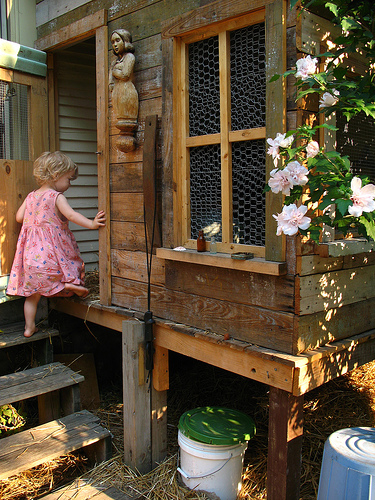

__Captions__:
* A child in a pink dress is climbing up a set of stairs in an entry way .
* A girl going into a wooden building .
* A little girl climbing into a wooden playhouse .
* A little girl climbing the stairs to her playhouse .
* A girl in a pink dress climb the stairs.


# preprocess dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd

class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, split_file, transform=None, tokenizer=None, max_length=77):
        # Load and prepare data
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file, sep='\t', names=['image', 'caption'])
        self.split_file = pd.read_csv(split_file, names=['image'])

        # Filter dataset based on split
        self.df['image'] = self.df['image'].apply(lambda x: x.split('#')[0])
        self.df = self.df[self.df['image'].isin(self.split_file['image'])]

        # Remove empty captions
        self.df = self.df[self.df['caption'].str.strip() != '']

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        caption = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.tokenizer:
            caption = tokenize_text(self.tokenizer, caption, self.max_length)
            if len(caption) == 0:
                print(f"Empty caption at index {idx}: {self.df.iloc[idx, 1]}")
        else:
            caption = torch.tensor([], dtype=torch.long)

        return image, caption
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

In [ ]:
train_dataset = Flickr8kDataset(
    image_dir='/content/Flicker8k_Dataset',
    captions_file='/content/Flickr8k.token.txt',
    split_file='/content/Flickr_8k.trainImages.txt',
    transform=transform,
    tokenizer=tokenizer,
    max_length=77
)

dev_dataset = Flickr8kDataset(
    image_dir='/content/Flicker8k_Dataset',
    captions_file='/content/Flickr8k.token.txt',
    split_file='/content/Flickr_8k.devImages.txt',
    tokenizer=tokenizer,
    max_length=77
)

test_dataset = Flickr8kDataset(
    image_dir='/content/Flicker8k_Dataset',
    captions_file='/content/Flickr8k.token.txt',
    split_file='/content/Flickr_8k.testImages.txt',
    tokenizer=tokenizer,
    max_length=77
)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Implement CLIP



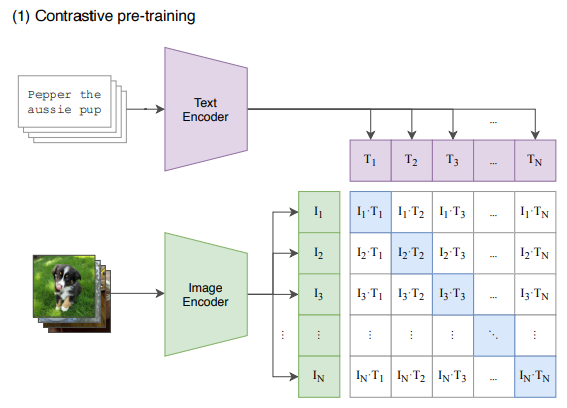

# Text Encoder

Text encoder functions by converting textual input into a numerical representation, allowing the model to understand and relate text to images. This encoder is trained on a vast array of internet text-image pairs, enabling it to recognize a wide range of concepts and relate them to visual content effectively.

In [ ]:
import torch
import torch.nn as nn

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, transformer_width, transformer_heads, transformer_layers, context_length, embed_dim):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.zeros(context_length, transformer_width))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=transformer_width, nhead=transformer_heads),
            num_layers=transformer_layers
        )
        self.ln_final = nn.LayerNorm(transformer_width)
        self.text_projection = nn.Linear(transformer_width, embed_dim)

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.02)
        nn.init.normal_(self.text_projection.weight, std=0.02)

    def forward(self, text):
      ### implement the code ###
        return x


# Image Encoder

It excels in understanding images in the context of natural language descriptions. Unlike traditional models that require specific training for each task, CLIP is versatile and can handle various tasks without task-specific training. It learns from a vast range of internet images and their associated text, enabling it to understand and categorize images in a way that aligns closely with human perception. CLIP's approach allows it to perform well across a broad spectrum of visual tasks, including object recognition and complex reasoning about images.

In [ ]:
import torch
import torch.nn as nn

class ImageEncoder(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        self.num_patches = (input_resolution // patch_size) ** 2
        self.positional_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, width))
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, width))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=width, nhead=heads),
            num_layers=layers
        )

        self.fc = nn.Linear(width, output_dim)

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.positional_embedding, std=0.02)
        nn.init.normal_(self.class_embedding, std=0.02)
        nn.init.normal_(self.fc.weight, std=0.02)

    def forward(self, x: torch.Tensor):
     ###implement the code###

        return x


# Contrastive loss


Contrastive loss in CLIP (Contrastive Language–Image Pretraining) helps the model learn by comparing pairs of images and text. It rewards the model when it correctly matches an image with its corresponding text, and penalizes it for incorrect matches. This approach effectively aligns the representations of images and text in a shared embedding space.

In [ ]:
def contrastive_loss(image_features, text_features, temperature=0.07):
    ###implement the code###

    return ???

In [ ]:
class CLIP(nn.Module):
    def __init__(self, embed_dim, image_resolution, vision_layers, vision_width, vision_patch_size, context_length, vocab_size, transformer_width, transformer_heads, transformer_layers):
        super().__init__()

        self.image_encoder = ImageEncoder(
            input_resolution=image_resolution,
            patch_size=vision_patch_size,
            width=vision_width,
            layers=vision_layers,
            heads=vision_heads,
            output_dim=embed_dim
        )
        self.text_encoder = TextEncoder(
            vocab_size=vocab_size,
            transformer_width=transformer_width,
            transformer_heads=transformer_heads,
            transformer_layers=transformer_layers,
            context_length=context_length,
            embed_dim=embed_dim
        )

        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, image, text):
        image_features = self.image_encoder(image)
        text_features = self.text_encoder(text)

        if image_features.dim() < 2:
            image_features = image_features.unsqueeze(0)
        if text_features.dim() < 2:
            text_features = text_features.unsqueeze(0)

        return image_features, text_features

# config

In [ ]:
image_resolution = 224
vision_patch_size = 16
vision_width = 768
vision_layers = 4
vision_heads = 12
embed_dim = 128
context_length = 77
vocab_size = 49408
transformer_width = 512
transformer_heads = 8
transformer_layers = 6

model = CLIP(
    embed_dim=512,
    image_resolution=224,
    vision_layers=12,
    vision_width=768,
    vision_patch_size=16,
    context_length=77,
    vocab_size=49408,
    transformer_width=512,
    transformer_heads=8,
    transformer_layers=6
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Train

In [ ]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch_idx, (images, captions) in enumerate(dataloader):
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()

        image_features, text_features = model(images, captions)

        loss = contrastive_loss(image_features, text_features)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(dataloader)}, Batch Loss: {loss.item()}")
        if batch_idx == 1:
            break
    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in dataloader:
            images, captions = images.to(device), captions.to(device)

            image_features = model.image_encoder(images)
            text_features = model.text_encoder(captions)

            if text_features is None:
              raise ValueError("text_features is None after encode_text")

            loss = contrastive_loss(image_features, text_features)
            total_loss += loss.item()

    return total_loss / len(dataloader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_dataloader, optimizer, device)


# zero-shot prediction
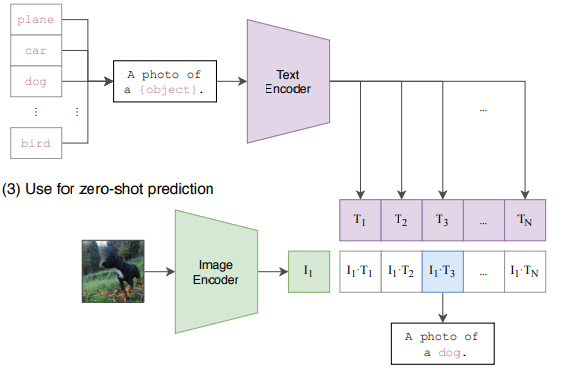

CLIP (Contrastive Language–Image Pre-training) zero-shot detection is an advanced AI technique that enables models to understand and identify objects in images without prior specific training on those objects. It combines natural language processing and computer vision, utilizing a large-scale dataset of images and text to learn visual concepts directly from language descriptions. This approach significantly expands the model's ability to recognize a wide variety of objects and scenes, as it can leverage language descriptions to interpret images it has never seen before. Zero-shot detection in CLIP is particularly powerful because it bypasses the need for extensive labeled datasets, making it versatile and efficient for diverse applications. The method demonstrates a remarkable understanding of both language and visual content, bridging the gap between textual and visual understanding in AI.

In [ ]:
# library for downloading data files
!pip install pooch

# Download all scikit-image example data.
import skimage
skimage.data.download_all()

# Load the model

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

# process text and image

In [ ]:
preprocess

In [ ]:
clip.tokenize("Hello World!")

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

In [ ]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
count = len(descriptions)
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()


# Classifier Free Guidance

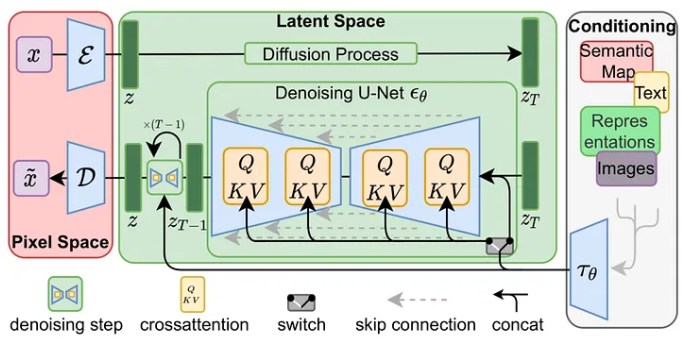

# Training a Class-Conditioned Diffusion Model with Classifier-Free Guidance

In this section, we demonstrate how to train a class-conditioned diffusion model using classifier-free guidance.

We'll use the MNIST dataset as an example, enabling the model to generate specific digits (0-9) based on user input during inference.

The classifier-free guidance technique is incorporated during training to improve sample quality and controllability.
It works by jointly training a conditional diffusion model (conditioned on class labels) and an unconditional diffusion model (not conditioned on any labels).


## Setup and Data Prep

In [ ]:
%pip install -q diffusers

In [ ]:
%pip install clip

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import os
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Data load

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## Creating a Class-Conditioned UNet


In [ ]:
from transformers import AutoModel, AutoConfig, AutoTokenizer

bert_config = AutoConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

In [ ]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=128):
    super().__init__()
    self.linear_layer = nn.Linear(class_emb_size, 128 * 28 * 28)
    self.class_emb = nn.Embedding(num_classes, class_emb_size)
    self.tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
    self.text_encoder = AutoModel.from_config(bert_config)

    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=3,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  def encode_labels_with_clip(self, labels):
       ###implement the code###
       '''
       transforming numerical or categorical class labels into descriptive text strings.
       if label is ""=> ""
       if label is 3 => A photo of digit 3
       Utilize Bert tokenizer and text encoding with BERT.
       '''
    return ???

  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape
    class_cond = self.encode_labels_with_clip(class_labels)
    class_cond = class_cond[:, 0, :]
    class_cond = self.linear_layer(class_cond)
    class_cond = class_cond.view(bs, 128, 28, 28)

    net_input = torch.cat((x, class_cond), 1)

    return self.model(net_input, t).sample

## Joint trainig a diffusion model with classifier-free guidance


In [ ]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
n_epochs = 10

net = ClassConditionedUnet().to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        x = x.to(device) * 2 - 1
        random_vals = torch.rand(x.shape[0], device=device)
        y_cond = [str(label.item()) if rand_val > 0.1 else "" for label, rand_val in zip(y, random_vals)]
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y_cond)

        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

Once training finishes, we can sample some images feeding in different labels as our conditioning:

# Conditional sampling with classifier-free guidance

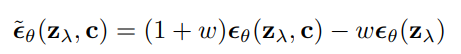

In [ ]:
guidance_scale = 7.5
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    t_tensor = torch.full((x.shape[0],), t, device=device)

    # Get model pred
    with torch.no_grad():
        noise_pred_text = net(x, t, y)

    with torch.no_grad():
        noise_pred_uncond = net(x, t, [""] * x.shape[0])
    # Apply guidance
    ###implement the code###

    # Update sample
    x = noise_scheduler.step(guided_noise, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')